In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import optuna
import joblib
import time


from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from skimage.feature import hog
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
try:
    dataset_path
except NameError:
    dataset_path = r"C:/Users/LENOVO/Documents/Projects/Python/CS231/archive/dataset"

TRAIN_FOLDER = os.path.join(dataset_path, 'train')
VALID_FOLDER = os.path.join(dataset_path, 'valid')

In [ ]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    if not os.path.exists(folder_path):
        print(f"Không tìm thấy đường dẫn: {folder_path}")
        return [], []
    
    class_names = sorted(os.listdir(folder_path))
    
    for cls in class_names:
        class_folder = os.path.join(folder_path, cls)
        if not os.path.isdir(class_folder): continue
        for fname in os.listdir(class_folder):
            img_path = os.path.join(class_folder, fname)
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(cls)
    return images, np.array(labels)

In [ ]:
def extract_sift_features(images, vocab=None, vocab_size=200):
    sift = cv2.SIFT_create()
    descriptor_list = []
    image_descriptors = []

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, des = sift.detectAndCompute(gray, None)
        image_descriptors.append(des)
        if des is not None: descriptor_list.append(des)

    if vocab is None:
        if not descriptor_list: return np.zeros((len(images), vocab_size)), None
        all_des = np.vstack(descriptor_list)
        kmeans = MiniBatchKMeans(n_clusters=vocab_size, batch_size=1000, n_init='auto', random_state=42)
        vocab = kmeans.fit(all_des)

    features = []
    for des in image_descriptors:
        if des is None or vocab is None:
            hist = np.zeros(vocab_size)
        else:
            words = vocab.predict(des)
            hist, _ = np.histogram(words, bins=range(vocab_size + 1))
            norm = np.linalg.norm(hist)
            if norm > 0: hist = hist / norm
        features.append(hist)
    return np.array(features), vocab

In [5]:
def extract_hog_features(images, resize_shape=(128, 128)): 
    hog_feats = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.resize(gray, resize_shape)
        f = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_feats.append(f)
    return np.array(hog_feats)

In [6]:
def extract_hist_features(images, bins=(8, 8, 8)):
    hist_feats = []
    for img in images:
        h = cv2.calcHist([img], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        cv2.normalize(h, h)
        hist_feats.append(h.flatten())
    return np.array(hist_feats)

In [7]:
def extract_resnet_features(images):
    X_processed = [cv2.resize(img, (224, 224)) for img in images]
    X_processed = np.array(X_processed, dtype=np.float32)
    X_processed = preprocess_input(X_processed)
    
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    features = model.predict(X_processed, batch_size=32, verbose=1)
    return features

In [ ]:
def optimize_svm_optuna(X_train, y_train, X_test, y_test, feat_name, n_trials=10):
    print(f"\n OPTUNA ({feat_name}) | Input Dim: {X_train.shape[1]}")
    start_time = time.time()
    
    if X_train.shape[1] > 1000:
        n_components = 300
        use_pca = True
    else:
        use_pca = False

    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

    def objective(trial):
        c = trial.suggest_float("C", 1e-2, 1e2, log=True)
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
        gamma = 'scale'
        if kernel == "rbf":
            gamma = trial.suggest_float("gamma", 1e-4, 0.1, log=True)
            
        steps = [('scaler', StandardScaler())]
        if use_pca:
            steps.append(('pca', PCA(n_components=n_components, random_state=42)))
            
        steps.append(('model', SVC(C=c, kernel=kernel, gamma=gamma, probability=True, random_state=42)))
        
        clf = Pipeline(steps)
        clf.fit(X_tr, y_tr)
        return accuracy_score(y_val, clf.predict(X_val))


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    best = study.best_params
    print(f"Best Params: {best}") 

    final_steps = [('scaler', StandardScaler())]
    if use_pca:
        final_steps.append(('pca', PCA(n_components=n_components, random_state=42)))
        
    final_model = SVC(C=best['C'], kernel=best['kernel'], gamma=best.get('gamma', 'scale'), probability=True, random_state=42)
    final_steps.append(('model', final_model))
    
    pipeline = Pipeline(final_steps)
    pipeline.fit(X_train, y_train)
    
    # Evaluate
    y_pred = pipeline.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"    Result ({feat_name}): Accuracy={test_acc:.4f} | F1-Score={test_f1:.4f}")
    print(f"    Time: {time.time() - start_time:.2f}s")
    
    return pipeline, test_acc, test_f1

In [9]:
X_train_img, y_train = load_images_from_folder(TRAIN_FOLDER)
X_test_img, y_test = load_images_from_folder(VALID_FOLDER)

results = {}

Đang tải dữ liệu từ C:/Users/LENOVO/Documents/Projects/Python/CS231/archive/dataset\train...
Đang tải dữ liệu từ C:/Users/LENOVO/Documents/Projects/Python/CS231/archive/dataset\valid...


In [10]:
# 1. SIFT
print("\n--- 1. SIFT ---")
X_tr_sift, vocab = extract_sift_features(X_train_img)
X_te_sift, _ = extract_sift_features(X_test_img, vocab=vocab)
model, acc, f1 = optimize_svm_optuna(X_tr_sift, y_train, X_te_sift, y_test, "SIFT")
results['SIFT'] = {'acc': acc, 'f1': f1, 'model': model, 'vocab': vocab}


--- 1. SIFT ---
   [SIFT] Xây dựng từ điển (K=200)...


[I 2025-12-14 09:44:57,930] A new study created in memory with name: no-name-4aaecc83-bc26-4537-b049-3814c7ebb3ee



⚡ OPTUNA (SIFT) | Input Dim: 200


Best trial: 0. Best value: 0.0366133:  10%|█         | 1/10 [00:44<06:38, 44.25s/it]

[I 2025-12-14 09:45:42,223] Trial 0 finished with value: 0.036613272311212815 and parameters: {'C': 61.07234512722668, 'kernel': 'rbf', 'gamma': 0.09624787275466726}. Best is trial 0 with value: 0.036613272311212815.


Best trial: 1. Best value: 0.503432:  20%|██        | 2/10 [01:01<03:47, 28.45s/it] 

[I 2025-12-14 09:45:59,631] Trial 1 finished with value: 0.5034324942791762 and parameters: {'C': 12.8831383627164, 'kernel': 'linear'}. Best is trial 1 with value: 0.5034324942791762.


Best trial: 1. Best value: 0.503432:  30%|███       | 3/10 [01:36<03:39, 31.36s/it]

[I 2025-12-14 09:46:34,446] Trial 2 finished with value: 0.08314263920671243 and parameters: {'C': 0.0674021112463045, 'kernel': 'rbf', 'gamma': 0.0018914191434708898}. Best is trial 1 with value: 0.5034324942791762.


Best trial: 1. Best value: 0.503432:  40%|████      | 4/10 [01:50<02:27, 24.50s/it]

[I 2025-12-14 09:46:48,439] Trial 3 finished with value: 0.5034324942791762 and parameters: {'C': 0.7587117097978049, 'kernel': 'linear'}. Best is trial 1 with value: 0.5034324942791762.


Best trial: 1. Best value: 0.503432:  50%|█████     | 5/10 [02:17<02:07, 25.56s/it]

[I 2025-12-14 09:47:15,845] Trial 4 finished with value: 0.031273836765827616 and parameters: {'C': 0.013066275550174615, 'kernel': 'rbf', 'gamma': 0.0007330618672920388}. Best is trial 1 with value: 0.5034324942791762.


Best trial: 5. Best value: 0.540809:  60%|██████    | 6/10 [02:47<01:47, 26.78s/it]

[I 2025-12-14 09:47:45,019] Trial 5 finished with value: 0.5408085430968727 and parameters: {'C': 1.855022040967022, 'kernel': 'rbf', 'gamma': 0.005253558612868752}. Best is trial 5 with value: 0.5408085430968727.


Best trial: 5. Best value: 0.540809:  70%|███████   | 7/10 [03:23<01:29, 29.84s/it]

[I 2025-12-14 09:48:21,159] Trial 6 finished with value: 0.43554538520213576 and parameters: {'C': 33.34955077219065, 'kernel': 'rbf', 'gamma': 0.01251221858802994}. Best is trial 5 with value: 0.5408085430968727.


Best trial: 5. Best value: 0.540809:  80%|████████  | 8/10 [03:36<00:49, 24.73s/it]

[I 2025-12-14 09:48:34,965] Trial 7 finished with value: 0.5034324942791762 and parameters: {'C': 10.557288053761104, 'kernel': 'linear'}. Best is trial 5 with value: 0.5408085430968727.


Best trial: 5. Best value: 0.540809:  90%|█████████ | 9/10 [04:02<00:25, 25.11s/it]

[I 2025-12-14 09:49:00,905] Trial 8 finished with value: 0.031273836765827616 and parameters: {'C': 0.016189228942806, 'kernel': 'rbf', 'gamma': 0.0007494585323116438}. Best is trial 5 with value: 0.5408085430968727.


Best trial: 5. Best value: 0.540809: 100%|██████████| 10/10 [04:16<00:00, 25.68s/it]


[I 2025-12-14 09:49:14,827] Trial 9 finished with value: 0.505720823798627 and parameters: {'C': 0.03802268062310063, 'kernel': 'linear'}. Best is trial 5 with value: 0.5408085430968727.
   🎯 Best Params: {'C': 1.855022040967022, 'kernel': 'rbf', 'gamma': 0.005253558612868752}
   🔥 Result (SIFT): Accuracy=0.5746 | F1-Score=0.5669
   ⏱️ Time: 297.86s


In [ ]:
print("\n--- 2. HOG ---")
X_tr_hog = extract_hog_features(X_train_img)
X_te_hog = extract_hog_features(X_test_img)
model, acc, f1 = optimize_svm_optuna(X_tr_hog, y_train, X_te_hog, y_test, "HOG")
results['HOG'] = {'acc': acc, 'f1': f1, 'model': model}


--- 2. HOG ---


[I 2025-12-14 09:51:03,266] A new study created in memory with name: no-name-97884f34-0083-48d8-b121-940ffe14e242



⚡ OPTUNA (HOG) | Input Dim: 8100


Best trial: 0. Best value: 0.0312738:  10%|█         | 1/10 [00:56<08:29, 56.64s/it]

[I 2025-12-14 09:51:59,891] Trial 0 finished with value: 0.031273836765827616 and parameters: {'C': 0.09070110320311923, 'kernel': 'rbf', 'gamma': 0.002041095994940678}. Best is trial 0 with value: 0.031273836765827616.


Best trial: 1. Best value: 0.0549199:  20%|██        | 2/10 [01:54<07:41, 57.64s/it]

[I 2025-12-14 09:52:58,236] Trial 1 finished with value: 0.05491990846681922 and parameters: {'C': 15.830006314478421, 'kernel': 'rbf', 'gamma': 0.0012029109649942657}. Best is trial 1 with value: 0.05491990846681922.


Best trial: 1. Best value: 0.0549199:  30%|███       | 3/10 [02:51<06:38, 56.99s/it]

[I 2025-12-14 09:53:54,471] Trial 2 finished with value: 0.031273836765827616 and parameters: {'C': 0.7361721567999544, 'kernel': 'rbf', 'gamma': 0.018468606902086026}. Best is trial 1 with value: 0.05491990846681922.


Best trial: 1. Best value: 0.0549199:  40%|████      | 4/10 [03:49<05:45, 57.62s/it]

[I 2025-12-14 09:54:53,039] Trial 3 finished with value: 0.031273836765827616 and parameters: {'C': 1.6011626014841938, 'kernel': 'rbf', 'gamma': 0.0591679274551121}. Best is trial 1 with value: 0.05491990846681922.


Best trial: 1. Best value: 0.0549199:  50%|█████     | 5/10 [04:44<04:43, 56.64s/it]

[I 2025-12-14 09:55:47,930] Trial 4 finished with value: 0.03279938977879481 and parameters: {'C': 0.9723030536262144, 'kernel': 'rbf', 'gamma': 0.006708627020007344}. Best is trial 1 with value: 0.05491990846681922.


Best trial: 1. Best value: 0.0549199:  60%|██████    | 6/10 [05:39<03:44, 56.17s/it]

[I 2025-12-14 09:56:43,199] Trial 5 finished with value: 0.031273836765827616 and parameters: {'C': 0.06171424054881748, 'kernel': 'rbf', 'gamma': 0.0028834963612405884}. Best is trial 1 with value: 0.05491990846681922.


Best trial: 6. Best value: 0.237986:  70%|███████   | 7/10 [06:19<02:31, 50.61s/it] 

[I 2025-12-14 09:57:22,369] Trial 6 finished with value: 0.2379862700228833 and parameters: {'C': 13.573672013523392, 'kernel': 'linear'}. Best is trial 6 with value: 0.2379862700228833.


Best trial: 6. Best value: 0.237986:  80%|████████  | 8/10 [07:16<01:45, 52.82s/it]

[I 2025-12-14 09:58:19,910] Trial 7 finished with value: 0.034324942791762014 and parameters: {'C': 30.285918265506677, 'kernel': 'rbf', 'gamma': 0.002676056367130091}. Best is trial 6 with value: 0.2379862700228833.


Best trial: 6. Best value: 0.237986:  90%|█████████ | 9/10 [07:54<00:48, 48.04s/it]

[I 2025-12-14 09:58:57,432] Trial 8 finished with value: 0.2379862700228833 and parameters: {'C': 0.013653476901025162, 'kernel': 'linear'}. Best is trial 6 with value: 0.2379862700228833.


Best trial: 6. Best value: 0.237986: 100%|██████████| 10/10 [08:50<00:00, 53.09s/it]


[I 2025-12-14 09:59:54,212] Trial 9 finished with value: 0.06178489702517163 and parameters: {'C': 1.3542112701688556, 'kernel': 'rbf', 'gamma': 0.000991786990155263}. Best is trial 6 with value: 0.2379862700228833.
   🎯 Best Params: {'C': 13.573672013523392, 'kernel': 'linear'}
   🔥 Result (HOG): Accuracy=0.2396 | F1-Score=0.2332
   ⏱️ Time: 584.05s


In [ ]:
print("\n--- 3. HIST ---")
X_tr_hist = extract_hist_features(X_train_img)
X_te_hist = extract_hist_features(X_test_img)
model, acc, f1 = optimize_svm_optuna(X_tr_hist, y_train, X_te_hist, y_test, "HIST")
results['HIST'] = {'acc': acc, 'f1': f1, 'model': model}


--- 3. HIST ---


[I 2025-12-14 10:00:51,310] A new study created in memory with name: no-name-385839f9-918c-4a8e-b144-6b738baaa3b1



⚡ OPTUNA (HIST) | Input Dim: 512


Best trial: 0. Best value: 0.408848:  10%|█         | 1/10 [00:18<02:42, 18.01s/it]

[I 2025-12-14 10:01:09,335] Trial 0 finished with value: 0.4088482074752098 and parameters: {'C': 0.28451714567610586, 'kernel': 'linear'}. Best is trial 0 with value: 0.4088482074752098.


Best trial: 0. Best value: 0.408848:  20%|██        | 2/10 [01:16<05:32, 41.62s/it]

[I 2025-12-14 10:02:07,468] Trial 1 finished with value: 0.13653699466056446 and parameters: {'C': 1.7198014436082556, 'kernel': 'rbf', 'gamma': 0.09411894171298277}. Best is trial 0 with value: 0.4088482074752098.


Best trial: 0. Best value: 0.408848:  30%|███       | 3/10 [01:36<03:42, 31.81s/it]

[I 2025-12-14 10:02:27,601] Trial 2 finished with value: 0.3897787948131198 and parameters: {'C': 0.010875172804035611, 'kernel': 'linear'}. Best is trial 0 with value: 0.4088482074752098.


Best trial: 0. Best value: 0.408848:  40%|████      | 4/10 [01:55<02:40, 26.82s/it]

[I 2025-12-14 10:02:46,784] Trial 3 finished with value: 0.39282990083905417 and parameters: {'C': 4.183559070139783, 'kernel': 'linear'}. Best is trial 0 with value: 0.4088482074752098.


Best trial: 0. Best value: 0.408848:  50%|█████     | 5/10 [02:52<03:08, 37.61s/it]

[I 2025-12-14 10:03:43,503] Trial 4 finished with value: 0.18306636155606407 and parameters: {'C': 25.6033121912002, 'kernel': 'rbf', 'gamma': 0.0592127370458154}. Best is trial 0 with value: 0.4088482074752098.


Best trial: 5. Best value: 0.417239:  60%|██████    | 6/10 [03:10<02:04, 31.14s/it]

[I 2025-12-14 10:04:02,106] Trial 5 finished with value: 0.41723874904652936 and parameters: {'C': 0.07034482831175551, 'kernel': 'linear'}. Best is trial 5 with value: 0.41723874904652936.


Best trial: 5. Best value: 0.417239:  70%|███████   | 7/10 [04:07<01:58, 39.57s/it]

[I 2025-12-14 10:04:59,038] Trial 6 finished with value: 0.05110602593440122 and parameters: {'C': 0.165555144957937, 'kernel': 'rbf', 'gamma': 0.07807725269013349}. Best is trial 5 with value: 0.41723874904652936.


Best trial: 5. Best value: 0.417239:  80%|████████  | 8/10 [04:26<01:05, 32.84s/it]

[I 2025-12-14 10:05:17,469] Trial 7 finished with value: 0.39511823035850496 and parameters: {'C': 3.11428190238542, 'kernel': 'linear'}. Best is trial 5 with value: 0.41723874904652936.


Best trial: 5. Best value: 0.417239:  90%|█████████ | 9/10 [04:44<00:28, 28.16s/it]

[I 2025-12-14 10:05:35,335] Trial 8 finished with value: 0.39588100686498856 and parameters: {'C': 0.761811401040697, 'kernel': 'linear'}. Best is trial 5 with value: 0.41723874904652936.


Best trial: 5. Best value: 0.417239: 100%|██████████| 10/10 [05:40<00:00, 34.01s/it]


[I 2025-12-14 10:06:31,364] Trial 9 finished with value: 0.28527841342486654 and parameters: {'C': 12.867004704185225, 'kernel': 'rbf', 'gamma': 0.02401854132961667}. Best is trial 5 with value: 0.41723874904652936.
   🎯 Best Params: {'C': 0.07034482831175551, 'kernel': 'linear'}
   🔥 Result (HIST): Accuracy=0.4267 | F1-Score=0.4169
   ⏱️ Time: 364.28s


In [13]:
# 4. RESNET50
print("\n--- 4. RESNET50 ---")
X_tr_res = extract_resnet_features(X_train_img)
X_te_res = extract_resnet_features(X_test_img)
model, acc, f1 = optimize_svm_optuna(X_tr_res, y_train, X_te_res, y_test, "RESNET50")
results['RESNET50'] = {'acc': acc, 'f1': f1, 'model': model}


--- 4. RESNET50 ---
205/205 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step

⚡ OPTUNA (RESNET50) | Input Dim: 2048


[I 2025-12-14 10:15:03,638] A new study created in memory with name: no-name-abc31d19-87d2-4f8f-8442-2f9f0d282fc0
Best trial: 0. Best value: 0.921434:  10%|█         | 1/10 [00:11<01:43, 11.51s/it]

[I 2025-12-14 10:15:15,160] Trial 0 finished with value: 0.9214340198321892 and parameters: {'C': 91.25672017608446, 'kernel': 'linear'}. Best is trial 0 with value: 0.9214340198321892.


Best trial: 0. Best value: 0.921434:  20%|██        | 2/10 [00:23<01:32, 11.53s/it]

[I 2025-12-14 10:15:26,700] Trial 1 finished with value: 0.9214340198321892 and parameters: {'C': 4.2894089698581634, 'kernel': 'linear'}. Best is trial 0 with value: 0.9214340198321892.


Best trial: 0. Best value: 0.921434:  30%|███       | 3/10 [01:08<03:08, 26.98s/it]

[I 2025-12-14 10:16:12,079] Trial 2 finished with value: 0.031273836765827616 and parameters: {'C': 0.011065125613578813, 'kernel': 'rbf', 'gamma': 0.06126947137211866}. Best is trial 0 with value: 0.9214340198321892.


Best trial: 0. Best value: 0.921434:  40%|████      | 4/10 [01:20<02:07, 21.27s/it]

[I 2025-12-14 10:16:24,569] Trial 3 finished with value: 0.9214340198321892 and parameters: {'C': 1.2865726514514917, 'kernel': 'linear'}. Best is trial 0 with value: 0.9214340198321892.


Best trial: 0. Best value: 0.921434:  50%|█████     | 5/10 [01:56<02:11, 26.38s/it]

[I 2025-12-14 10:17:00,031] Trial 4 finished with value: 0.16552250190694126 and parameters: {'C': 0.06197151550306223, 'kernel': 'rbf', 'gamma': 0.0002165631300139553}. Best is trial 0 with value: 0.9214340198321892.


Best trial: 0. Best value: 0.921434:  60%|██████    | 6/10 [02:08<01:26, 21.60s/it]

[I 2025-12-14 10:17:12,351] Trial 5 finished with value: 0.9214340198321892 and parameters: {'C': 2.0259141421726765, 'kernel': 'linear'}. Best is trial 0 with value: 0.9214340198321892.


Best trial: 0. Best value: 0.921434:  70%|███████   | 7/10 [02:20<00:55, 18.55s/it]

[I 2025-12-14 10:17:24,600] Trial 6 finished with value: 0.9214340198321892 and parameters: {'C': 0.24405230883252182, 'kernel': 'linear'}. Best is trial 0 with value: 0.9214340198321892.


Best trial: 0. Best value: 0.921434:  80%|████████  | 8/10 [02:32<00:32, 16.34s/it]

[I 2025-12-14 10:17:36,214] Trial 7 finished with value: 0.9214340198321892 and parameters: {'C': 5.275620603554185, 'kernel': 'linear'}. Best is trial 0 with value: 0.9214340198321892.


Best trial: 0. Best value: 0.921434:  90%|█████████ | 9/10 [03:20<00:26, 26.11s/it]

[I 2025-12-14 10:18:23,810] Trial 8 finished with value: 0.17467581998474446 and parameters: {'C': 18.518727702141817, 'kernel': 'rbf', 'gamma': 0.006424218524066208}. Best is trial 0 with value: 0.9214340198321892.


Best trial: 0. Best value: 0.921434: 100%|██████████| 10/10 [04:02<00:00, 24.26s/it]


[I 2025-12-14 10:19:06,217] Trial 9 finished with value: 0.031273836765827616 and parameters: {'C': 0.025023308213208948, 'kernel': 'rbf', 'gamma': 0.003576059219505075}. Best is trial 0 with value: 0.9214340198321892.
   🎯 Best Params: {'C': 91.25672017608446, 'kernel': 'linear'}
   🔥 Result (RESNET50): Accuracy=0.9230 | F1-Score=0.9207
   ⏱️ Time: 258.00s


In [ ]:
print("\n" + "="*60)
print("           FINAL RESULTS (ACCURACY & F1-SCORE)           ")
print("="*60)

summary_data = []
for name, res in results.items():
    summary_data.append({
        'Method': name, 
        'Accuracy': res['acc'], 
        'F1-Score (Weighted)': res['f1']
    })

df_res = pd.DataFrame(summary_data)

df_res = df_res.sort_values(by='F1-Score (Weighted)', ascending=False)
print(df_res)


best_name = df_res.iloc[0]['Method']
best_entry = results[best_name]

print(f"\n WINNER (Best F1): {best_name}")
joblib.dump(best_entry['model'], "best_model_f1.pkl")
joblib.dump(sorted(os.listdir(TRAIN_FOLDER)), "class_names.pkl")

if best_name == 'SIFT':
    joblib.dump(best_entry['vocab'], "sift_vocab.pkl")


           FINAL RESULTS (ACCURACY & F1-SCORE)           
     Method  Accuracy  F1-Score (Weighted)
3  RESNET50  0.922983             0.920739
0      SIFT  0.574572             0.566920
2      HIST  0.426650             0.416885
1       HOG  0.239609             0.233223

🏆 WINNER (Best F1): RESNET50



  VISUALIZATION: RESNET50


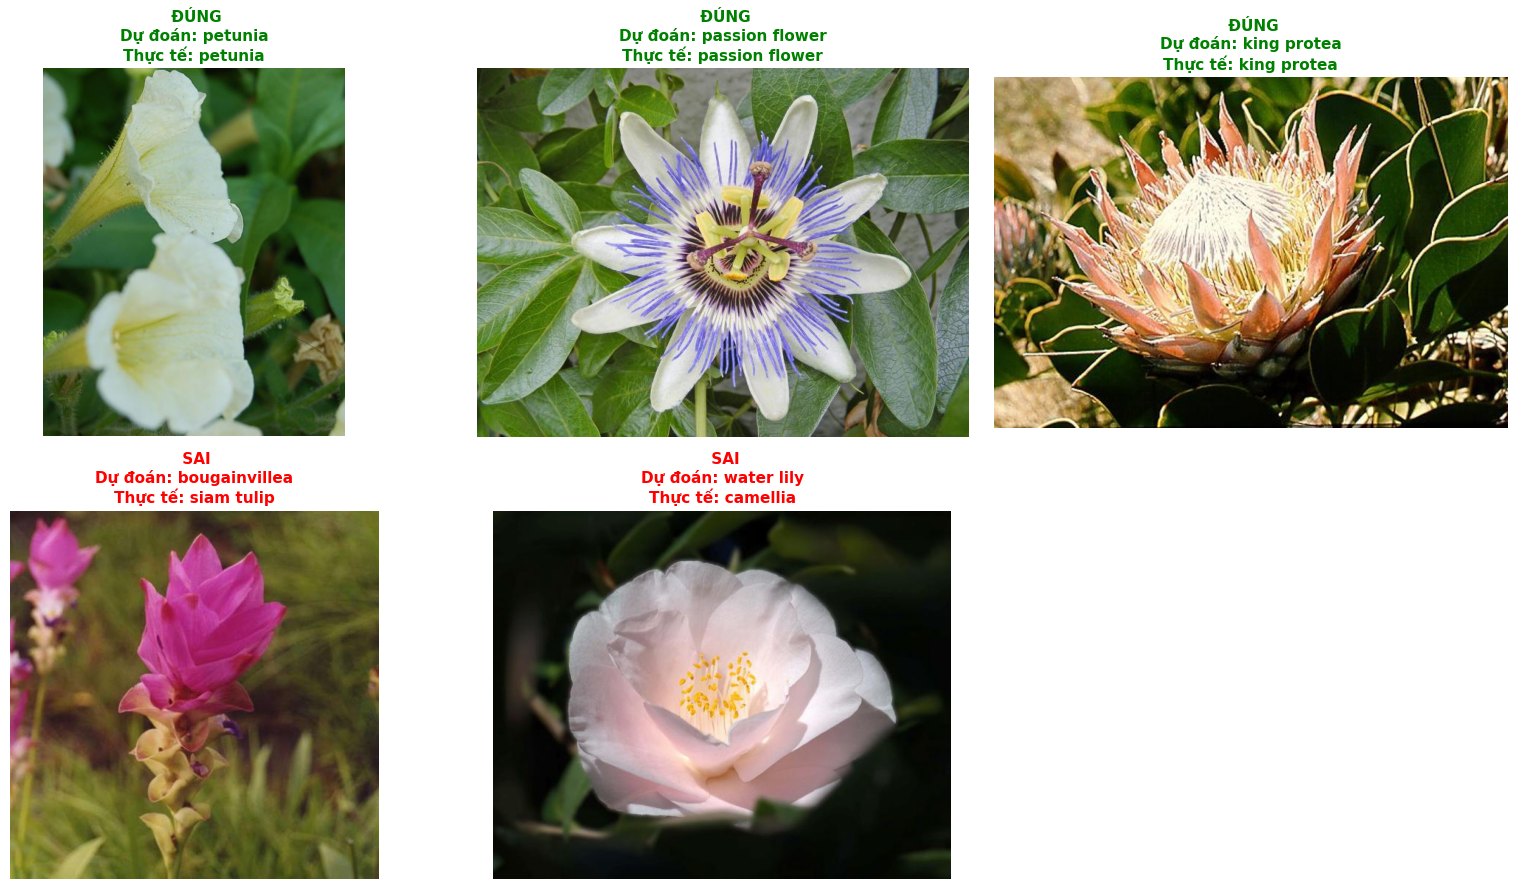

In [ ]:
import json
import matplotlib.pyplot as plt

# --- CẬP NHẬT PHẦN VISUALIZATION (Dự đoán trước - Thực tế sau) ---

print("\n" + "="*60)
print(f"  VISUALIZATION: {best_name}")
print("="*60)


cat_to_name = {
    "21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", 
    "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", 
    "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", 
    "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", 
    "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", 
    "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", 
    "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", 
    "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", 
    "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", 
    "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", 
    "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", 
    "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", 
    "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", 
    "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", 
    "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", 
    "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", 
    "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", 
    "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", 
    "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", 
    "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", 
    "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", 
    "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", 
    "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", 
    "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", 
    "51": "petunia"
}

def get_flower_name(label_id):
    return cat_to_name.get(str(label_id), str(label_id))

if best_name == 'SIFT':
    X_test_final = X_te_sift
elif best_name == 'HOG':
    X_test_final = X_te_hog
elif best_name == 'HIST':
    X_test_final = X_te_hist
elif best_name == 'RESNET50':
    X_test_final = X_te_res
else:
    raise ValueError("Unknown model name")

y_pred_final = best_entry['model'].predict(X_test_final)

correct_indices = np.where(y_test == y_pred_final)[0]
wrong_indices = np.where(y_test != y_pred_final)[0]

np.random.seed(42)
show_correct = np.random.choice(correct_indices, 3, replace=False) if len(correct_indices) >= 3 else correct_indices
show_wrong = np.random.choice(wrong_indices, 2, replace=False) if len(wrong_indices) >= 2 else wrong_indices

plt.figure(figsize=(16, 9))

for i, idx in enumerate(show_correct):
    plt.subplot(2, 3, i + 1)
    
    real_name = get_flower_name(y_test[idx])
    pred_name = get_flower_name(y_pred_final[idx])
    
    plt.imshow(X_test_img[idx])

    plt.title(f" ĐÚNG\nDự đoán: {pred_name}\nThực tế: {real_name}", color='green', fontsize=11, fontweight='bold')
    plt.axis('off')


for i, idx in enumerate(show_wrong):
    plt.subplot(2, 3, i + 4)
    
    real_name = get_flower_name(y_test[idx])
    pred_name = get_flower_name(y_pred_final[idx])
    
    plt.imshow(X_test_img[idx])

    plt.title(f" SAI\nDự đoán: {pred_name}\nThực tế: {real_name}", color='red', fontsize=11, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()